In [700]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm
import matplotlib.gridspec as gridspec
from factanal.wrapper import factanal
import json
import seaborn as sns

import geopandas as gp
import descartes
# import geoplot

# import geoplot.crs as gcrs

from scipy import signal
from sklearn.decomposition import FastICA, PCA

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import zscore

from sklearn.decomposition import non_negative_factorization, NMF

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [701]:
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [702]:
def scree_plot(ev,df):    
    plt.plot(range(1,df.shape[1]+1),ev,'-o',color='b')
    plt.title('Scree Plot')
    plt.xlabel('Number of factors')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1,c='r')
    plt.show();
       
def perform_fa(df, NUM, rotation, scores_method, method):
    
    fa = factanal(df, factors=NUM, scores=scores_method, rotation=rotation,  #'Bartlett','regression'
                  verbose=True, return_dict=True)
    
#     fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method=method) 
#     fa.fit(df)
    return fa


def loadings_plot(Loadings, col_names):
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(abs(Loadings))
    fig.colorbar(c, ax=ax)
    ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
    ax.set_yticklabels(col_names)
    ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
    plt.show();   
    
def plot_map(gdf,stations): 
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(figsize=(10, 10),color='w',edgecolor='k')
    print(stations['factor'].unique())
    df.plot(ax=ax,c=stations['factor'])
#     plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/map_3_factors.png", dpi=500)
    for k, v in df.iterrows():
#         ax.annotate(np.round(v.max_load,2),(v.Lon,v.Lat),size=6)
        ax.annotate(v.name,(v.Lon,v.Lat),size=6)
    plt.show();
    
      
def plot_factors_and_loadings(df_scores,df_load, list_of_factors, station_names, weekend_removed, to_save):
    mpl.style.use('seaborn-white')
#     cm = ['c','m','#d9534f','#9ad801']
    cm = sns.color_palette(None, len(list_of_factors))
    
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 4)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:3])  # top left
    df_scores.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')

    ax2 = plt.subplot(grid[1,:3])   # middle left
    df_scores.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)

    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')


    ax3 = plt.subplot(grid[2,:3])  # bottom left
    
    # don't include the weekend in the plot
    df_scores[df_scores['week day'].isin([0,1,2,3,4])].groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')


    ax4 = plt.subplot(grid[0:3,3:5])  # all right

    df_load[list_of_factors].plot(kind='barh', stacked=True, color=cm,ax=ax4,legend=True)
    ax4.legend(bbox_to_anchor=(1.7, 1), loc=2 ,frameon=True)
    ax4.set_yticks(np.arange(0,len(station_names)))
    ax4.set_yticklabels(station_names)
    ax4.yaxis.tick_right()
    ax4.set_facecolor('white')
    plt.xlabel('\nLoadings')
    # plt.show();
    
    plt.rcParams.update({'font.size': 14})
    fig.tight_layout()
    if to_save:
        plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/change_name.png", dpi=500)
    
    plt.show();
    
    
def test_if_FA_suitable(df):
    
    # Bartlett’s Test - p-value should be significant
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    # Kaiser-Meyer-Olkin (KMO) Test - between 0 and 1 - when 1 is highly suitable for factor analysis
    kmo_all,kmo_model=calculate_kmo(df)
    return p_value, kmo_model
    
    
def add_group_columns_to_df_scores(df_scores,times):
    df_scores['datetime'] = pd.to_datetime(times['time'], format='%Y-%m-%d %H:%M')
    df_scores['month'] = pd.to_datetime(times['time']).dt.month
    df_scores['hour'] = pd.to_datetime(times['time']).dt.hour
    df_scores['minute'] = pd.to_datetime(times['time']).dt.minute
    df_scores['Day in year'] = pd.to_datetime(times['time']).dt.dayofyear
  
    df_scores['week day'] = pd.to_datetime(times['time']).dt.dayofweek+1
#     print(df_scores['week day'].unique())
    df_scores.loc[df_scores['week day']==7,'week day']=0
#     print(df_scores['week day'].unique())
    
    return df_scores

def plot_time_series_sections(df,list_of_factors,times,weekend_removed):
    
    df = add_group_columns_to_df_scores(df,times)
    cm = sns.color_palette(None, len(list_of_factors))
    
    mpl.style.use('seaborn-white')
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 1)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:1])  # top left
    df.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
#     plt.ylim([-100,100])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=2 ,frameon=True)

    ax2 = plt.subplot(grid[1,:1])   # middle left
    df.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    
    
    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')

    ax3 = plt.subplot(grid[2,:1])  # bottom left
    df[df['week day'].isin([0,1,2,3,4])].groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')

    fig.tight_layout()
    plt.show();
    
    
    
def get_FA_results(df, times,  NUM, rotation, gdf, weekend_removed, show_factors, to_save, scores_method):

    mpl.style.use('default')
#     print(test_if_FA_suitable(df))
    
#     # scree plot
#     fa = FactorAnalyzer()
#     fa.fit(df)
#     ev, _ = fa.get_eigenvalues()
#     scree_plot(ev,df)
    
#     df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
    
    # FA
    fa = perform_fa(df, NUM, rotation, scores_method, method = 'ml')
    
#     # print cummulative variance
#     print(fa.get_factor_variance())

    # print uniqueneses
#     print(fa['uniquenesses'])
    
    # plot loadings 
#     # with factorAnalyzer()
#     Loadings = fa.loadings_
#     scores = fa.transform(df) # numerical value, no units

    # with factanal (R)
    Loadings = np.array(fa['loadings'])
    scores = np.array(fa['scores']) # numerical value, no units
    rotmat = []
#     if rotation == 'none':
#         rotmat = []
#     else: 
#         rotmat = np.array(fa['rotmat'])
    
    col_names = df.columns
#     loadings_plot(Loadings, col_names)
    
#     # plot stations  
#     # ascribe a factor to each station based on max loading value (and show it on map)
#     stations = stations[stations.name.isin(df.columns)]
#     stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
#     stations['max_load'] = np.max(abs(Loadings),axis=1)
#     plot_map(gdf,stations)
    
    # plot factors and loadings 
    FACTOR_COLUMNS = ['F'+str(i+1) for i in range(NUM)]
    
    if (show_factors == 'all'): 
        list_of_factors = FACTOR_COLUMNS      
#         print('Hi')
    else:
        list_of_factors = show_factors
        
    
    df_load = pd.DataFrame(Loadings,columns=FACTOR_COLUMNS)
    df_scores = pd.DataFrame(scores, columns=FACTOR_COLUMNS)
#     print(df_scores.index)
#     print(times.index)
    df_scores = add_group_columns_to_df_scores(df_scores,times)
#     print(df_scores.head())
#     print(df_scores['week day'].unique())


#     # UNSTANDARDIZE FACTORS
#     for i in range(NUM):
#         df_scores.iloc[:,i] = df.mean(axis=1) + df.std(axis=1)*df_scores.iloc[:,i].values
    
    plot_factors_and_loadings(df_scores,df_load, list_of_factors, df.columns, weekend_removed, to_save)
    plt.rcParams.update({'font.size': 14})
    
    return rotmat, Loadings, scores



In [703]:
def initialize():
#     df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1_fixed_2012_2019.csv")
#     times = pd.read_csv("~/Documents/saved_data_from_notebooks/times_df_2012_2019.csv")
    times = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/times_df_2012_2019.csv")
#     df = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/RF_add1_fixed_2012_2019.csv")
    df = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/final_imputed_df_mix")
    
    to_keep = ['ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'PETAH_TIKVA_ROAD', 'REMEZ',
       'YAD_LEBANIM', 'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KAKAL',
       'KIRYAT_ATA', 'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON',
       'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN', 'EFRATA', 'NAVE_ILAN',
       'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'DALYA', 'GEDERA', 'GVARAAM',
       'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV',
       'YAHALOM', 'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'HEFZIBA',
       'PARDES_HANA', 'RAANANA']  
    
    df = df.loc[:,df.columns.isin(to_keep)]
    
#     df.drop(columns = 'Unnamed: 0',inplace=True)
    times.drop(columns = 'Unnamed: 0',inplace=True)
    times.rename({'0': 'time'}, axis = 'columns',inplace=True)
    
    # NOTE THIS STATION FILE WAS GENERATED FOR 34 STATIONS OF 2013-2018
    stations = pd.read_csv("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stations_info_38.csv")
#     gdf = gp.read_file("/home/idit/Documents/saved_data_from_notebooks/IsraelBorder.shp")
#     stations = pd.read_csv("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stations_info.csv") 
    gdf = gp.read_file("/Users/iditbela/Documents/Broday/GIS/IsraelBorder/IsraelBorder.shp")

    return df,times,stations,gdf

## FA

In [886]:
remove_weekends = False
# chosen_months = [5,6,7]
# chosen_months = [11,12,1,2]
chosen_months = [1,2,3,4,5,6,7,8,9,10,11,12]

In [887]:
# initialize to get times:
df,times,stations,gdf = initialize()

# choose the type of data I want to FA (i.e., REMOVE STATIONS/EXTREME EVENTS...)

# extreme events/only the dust storm
pm_threshold = 600000

# remove dust storms in 2015 and 100
time_condition = [(((times.time>='2015-02-10 00:00:00') & (times.time<='2015-02-12 23:30:00')) | ((times.time>='2015-09-07 00:00:00') & (times.time<='2015-09-12 23:30:00'))
#                   | ((times.time>='2017-01-01 00:00:00'))
#                   | ((times.time>='2015-01-06 07:30:00') & (times.time<='2015-01-08 10:00:00'))
                  | ((df.values > pm_threshold).any(axis=1))
                  )]

idx_to_drop = np.argwhere(time_condition)[:,1]
df.drop(idx_to_drop,axis = 0, inplace=True)
times.drop(idx_to_drop,axis = 0, inplace=True)


# choose months
df['month'] = pd.to_datetime(times['time']).dt.month
times = times[df.month.isin(chosen_months)]
df = df[df.month.isin(chosen_months)]
df.drop(['month'],axis = 1, inplace =True)
# reset index!
df.reset_index(inplace=True)
df.drop(labels = 'index',axis=1, inplace=True)
times.reset_index(inplace=True)
times.drop(labels = 'index',axis=1, inplace=True)

# remove stations
STATIONS_TO_DROP = []
# STATIONS_TO_DROP = 'EAST_NEGEV'
# STATIONS_TO_DROP = ['AFULA', 'KVISH4',
#        'YEFET_YAFO', 'KIRYAT_ATA', 'KIRYAT_BIALIK',  'NESHER', 'BAR_ILAN',
#        'EFRATA',  'ASHKELON_SOUTH', 'GEDERA',
#        'KIRYAT_MALAHI', 'ORT', 'ROVA_TV', 
#        'YAHALOM', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA',
#        'RAANANA']
# STATIONS_TO_DROP = ['BAR_ILAN','ATZMAUT_B','KIRYAT_BINYAMIN','KFAR_MASARIK','KIRYAT_TIVON','IRONID','KVISH4','REMEZ','YEFET_YAFO','RAANANA','EAST_NEGEV','EFRATA','AFULA','PARDES_HANA','BEER_SHEVA']

# # traffic stations:
# STATIONS_TO_DROP = ['BAR_ILAN','IRONID','KVISH4','REMEZ','YEFET_YAFO','ATZMAUT_B','RAANANA','NAVE_ILAN','KAKAL']

# # traffic and distant stations:
# STATIONS_TO_DROP = ['BAR_ILAN','IRONID','KVISH4','REMEZ','YEFET_YAFO','ATZMAUT_B','RAANANA','NAVE_ILAN','KAKAL','EFRATA','EAST_NEGEV','NAVE_ILAN','BEER_SHEVA']


# distant stations:
# STATIONS_TO_DROP = ['IRONID','BAR_ILAN','EFRATA','EAST_NEGEV']
# not in the coast:
# STATIONS_TO_DROP = ['IRONID','BAR_ILAN','EFRATA','EAST_NEGEV','BEER_SHEVA','AFULA']


# # ONLY SOUTH
# STATIONS_TO_DROP = ['BAR_ILAN','AFULA', 'ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ',
#        'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK',
#        'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'EFRATA',
#        'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA','BEER_SHEVA'] 

# # ONLY NORTH
# STATIONS_TO_DROP = ['BAR_ILAN','ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ','NAVE_ILAN','PETAH_TIKVA_ROAD','YAD_LEBANIM','DALYA','HEFZIBA',
#        'YEFET_YAFO','EFRATA','ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI',
#        'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM',
#        'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA']#,'ATZMAUT_B','AFULA']

# # ONLY CENTER
# STATIONS_TO_DROP = ['AFULA', 'ANTOKOLSKY', 'IRONID', 'KVISH4', 'REMEZ',
#        'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK',
#        'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN',
#        'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM',
#        'KIRYAT_MALAHI', 'NIR_ISRAEL', 'SDEROT', 'SDE_YOAV',
#        'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA',
#        'RAANANA']# 'ORT', 'ROVA_TV'


# # REMOVE NORTH and EAST
# STATIONS_TO_DROP = ['BAR_ILAN','EFRATA','EAST_NEGEV','AHUZA_G','KAKAL','BEER_SHEVA','NAVE_ILAN',
#                     'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK','KIRYAT_BINYAMIN',
#                     'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'KFAR_MASARIK', 'PARDES_HANA','HEFZIBA']

# REMOVE NORTH 
STATIONS_TO_DROP = ['AHUZA_G','KAKAL','ATZMAUT_B',
                     'KIRYAT_ATA', 'KIRYAT_BIALIK','KIRYAT_BINYAMIN',
                    'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'KFAR_MASARIK', 'PARDES_HANA','HEFZIBA']



# # REMOVE NORTH and TRAFFIC and EAST
# STATIONS_TO_DROP = ['BAR_ILAN','EFRATA','EAST_NEGEV','AHUZA_G','NAVE_ILAN',
#                     'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK','KIRYAT_BINYAMIN',
#                     'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'KFAR_MASARIK', 'PARDES_HANA','HEFZIBA',
#                     'KVISH4','REMEZ','YEFET_YAFO','RAANANA','BEER_SHEVA']


# # STATIONS WITH NEGATIVE TRAFFIC VALUES:
# STATIONS_TO_DROP = ['AHUZA_G', 'KAKAL', 'KIRYAT_ATA', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN',
#                     'DALYA', 'GVARAAM', 'KIRYAT_MALAHI', 'SDEROT', 'SDE_YOAV', 'EAST_NEGEV', 'KFAR_MASARIK'
#                    ]


df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
stations = stations[stations.Name.isin(df.columns)]

# # remove stations
# STATIONS_TO_INCLUDE = ['ATZMAUT_B','KIRYAT_BIALIK','AHUZA_G','KIRYAT_ATA','KIRYAT_BINYAMIN','KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'KFAR_MASARIK']

# df = df[STATIONS_TO_INCLUDE]

# RESET INDEX!!!!
times.reset_index(inplace=True,drop=True)
df.reset_index(inplace=True,drop=True)

In [888]:
df.shape
times.shape

(139824, 26)

(139824, 1)

Uniquenesses: 
      ANTOKOLSKY            HOLON           IRONID           KVISH4 
           0.090            0.243            0.244            0.254 
PETAH_TIKVA_ROAD            REMEZ      YAD_LEBANIM       YEFET_YAFO 
           0.087            0.300            0.125            0.352 
        BAR_ILAN           EFRATA        NAVE_ILAN      ASHDOD_IGUD 
           0.348            0.125            0.137            0.186 
  ASHKELON_SOUTH            DALYA           GEDERA          GVARAAM 
           0.302            0.223            0.142            0.191 
   KIRYAT_MALAHI       NIR_ISRAEL              ORT          ROVA_TV 
           0.155            0.162            0.112            0.101 
          SDEROT         SDE_YOAV          YAHALOM       BEER_SHEVA 
           0.173            0.166            0.212            0.338 
      EAST_NEGEV          RAANANA 
           0.408            0.255 

Loadings:
                 Factor1 Factor2 Factor3 Factor4
ANTOKOLSKY        0.932    

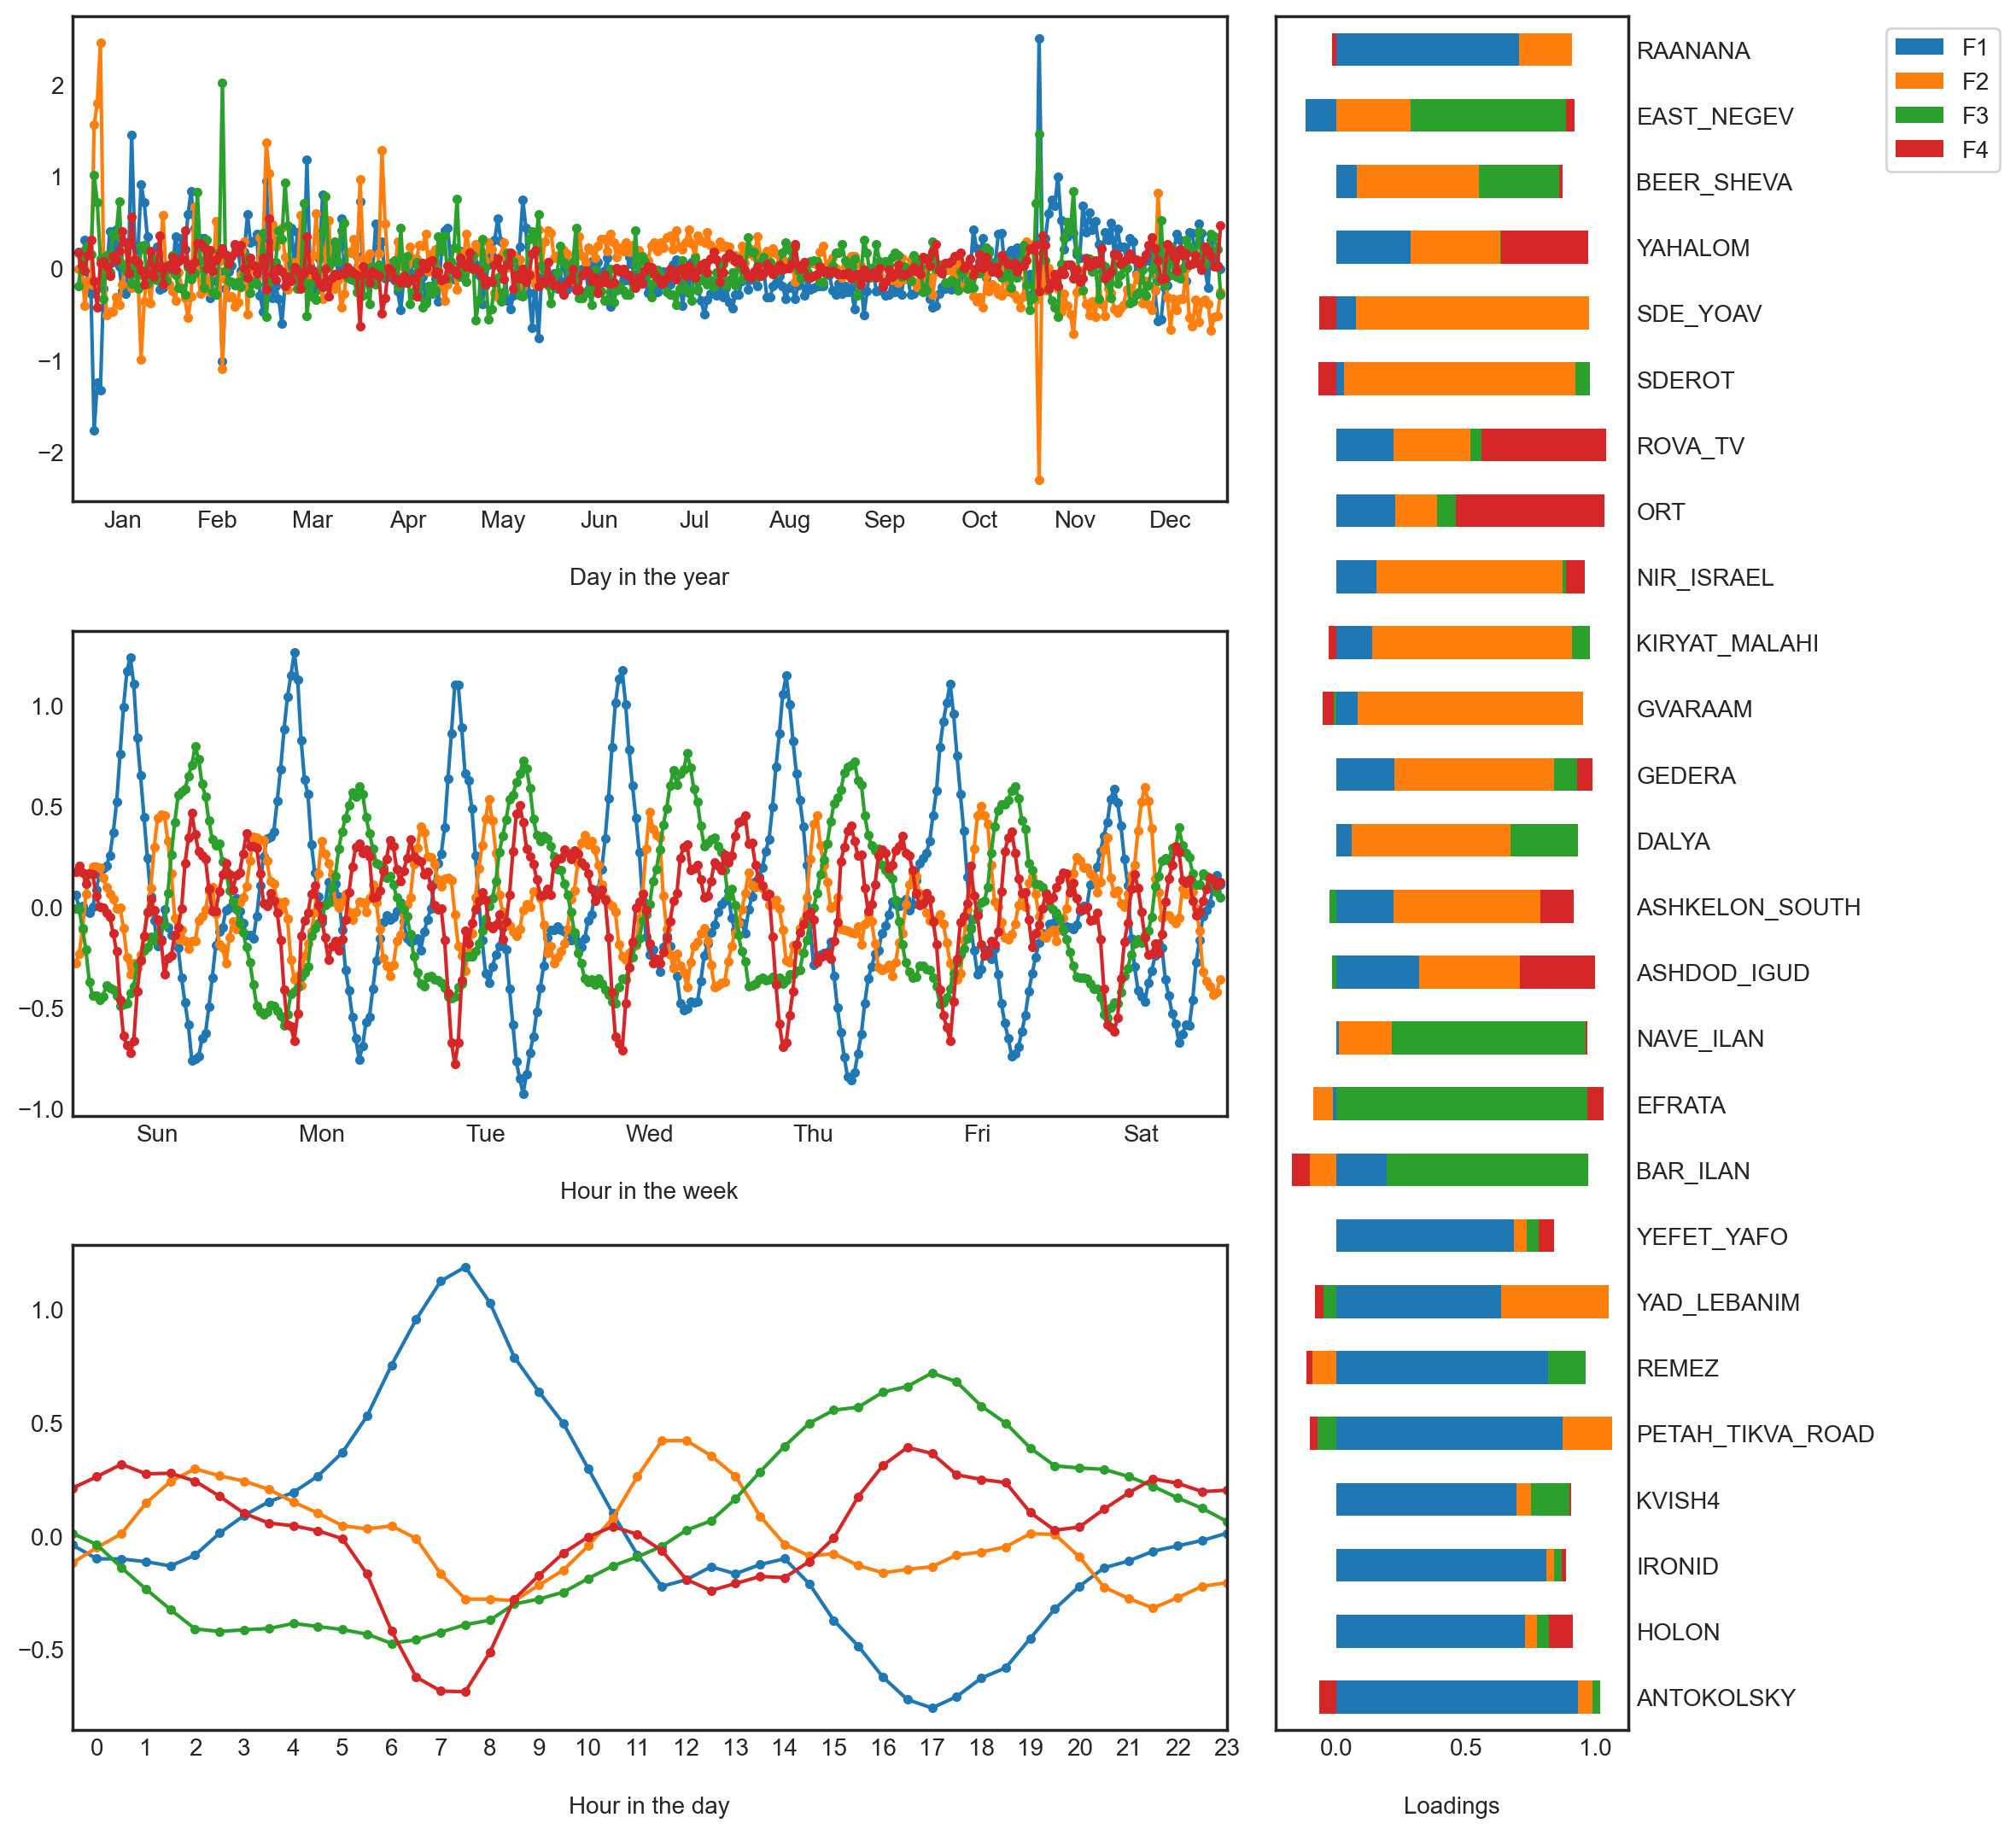

In [889]:
# NOTICE THAT WHEN I USE OBLIQUE ROTATION (PROMAX) I GET THE PATTERN MATRIX (NOT THE STRUCTURE)
# WHEN I USE VARIMAX, I GET THE STRUCTURE MATRIX (CUMMUNALITIES ARE CALCULATED BY IT)

# The pattern matrix holds the loadings.  Each row of the pattern matrix is essentially a regression equation where the standardized observed variable is expressed as a function of the factors. The loadings are the regression coefficients. The structure matrix holds the correlations between the variables and the factors.

weekend_removed = False
show_factors = 'all'

NUM = 4
rotation = 'promax'
# varimax tries to maximize variance among the squared values of loadings of each factor. Does this mean it's not necessarily the amount of variance traffic accounts for?

to_save = False
scores_method = 'regression'  #'Bartlett','regression'
rotmat, Loadings, scores = get_FA_results(df, times, NUM, rotation, gdf, weekend_removed, show_factors, to_save, scores_method)

In [708]:
Loadings

array([[ 9.31847337e-01,  5.84243738e-02,  2.96747488e-02,
        -6.59609583e-02],
       [ 7.27996514e-01,  4.69105829e-02,  4.43184637e-02,
         9.23782175e-02],
       [ 8.09326237e-01,  2.96610856e-02,  3.18611628e-02,
         1.62995613e-02],
       [ 6.95012003e-01,  5.47597006e-02,  1.50675706e-01,
         7.33305134e-03],
       [ 8.71911418e-01,  1.92803796e-01, -7.23013983e-02,
        -3.04620881e-02],
       [ 8.15889439e-01, -9.39630378e-02,  1.45699476e-01,
        -2.30358461e-02],
       [ 6.36464296e-01,  4.16175094e-01, -5.08770512e-02,
        -3.37523133e-02],
       [ 6.86068469e-01,  4.93867823e-02,  4.53881409e-02,
         5.82280435e-02],
       [ 1.94649143e-01, -1.02270655e-01,  7.76647909e-01,
        -7.03039249e-02],
       [-1.26842619e-02, -7.87069685e-02,  9.68302368e-01,
         6.27810351e-02],
       [ 9.91236925e-03,  2.02951558e-01,  7.50996433e-01,
         5.37517767e-03],
       [ 3.19450674e-01,  3.87909285e-01, -1.85747207e-02,
      

### Calculate factor scores 

In [959]:
from numpy.linalg import inv as inverse

In [960]:
F = np.dot(np.dot(inverse(np.dot(Loadings.T,Loadings)),Loadings.T),np.transpose(df.values))

In [961]:
df_scores = pd.DataFrame.from_records(F.T, columns=['F1','F2','F3','F4'])
df_load = pd.DataFrame.from_records(Loadings, columns=['F1','F2','F3','F4'])

In [962]:
column_names = df.columns

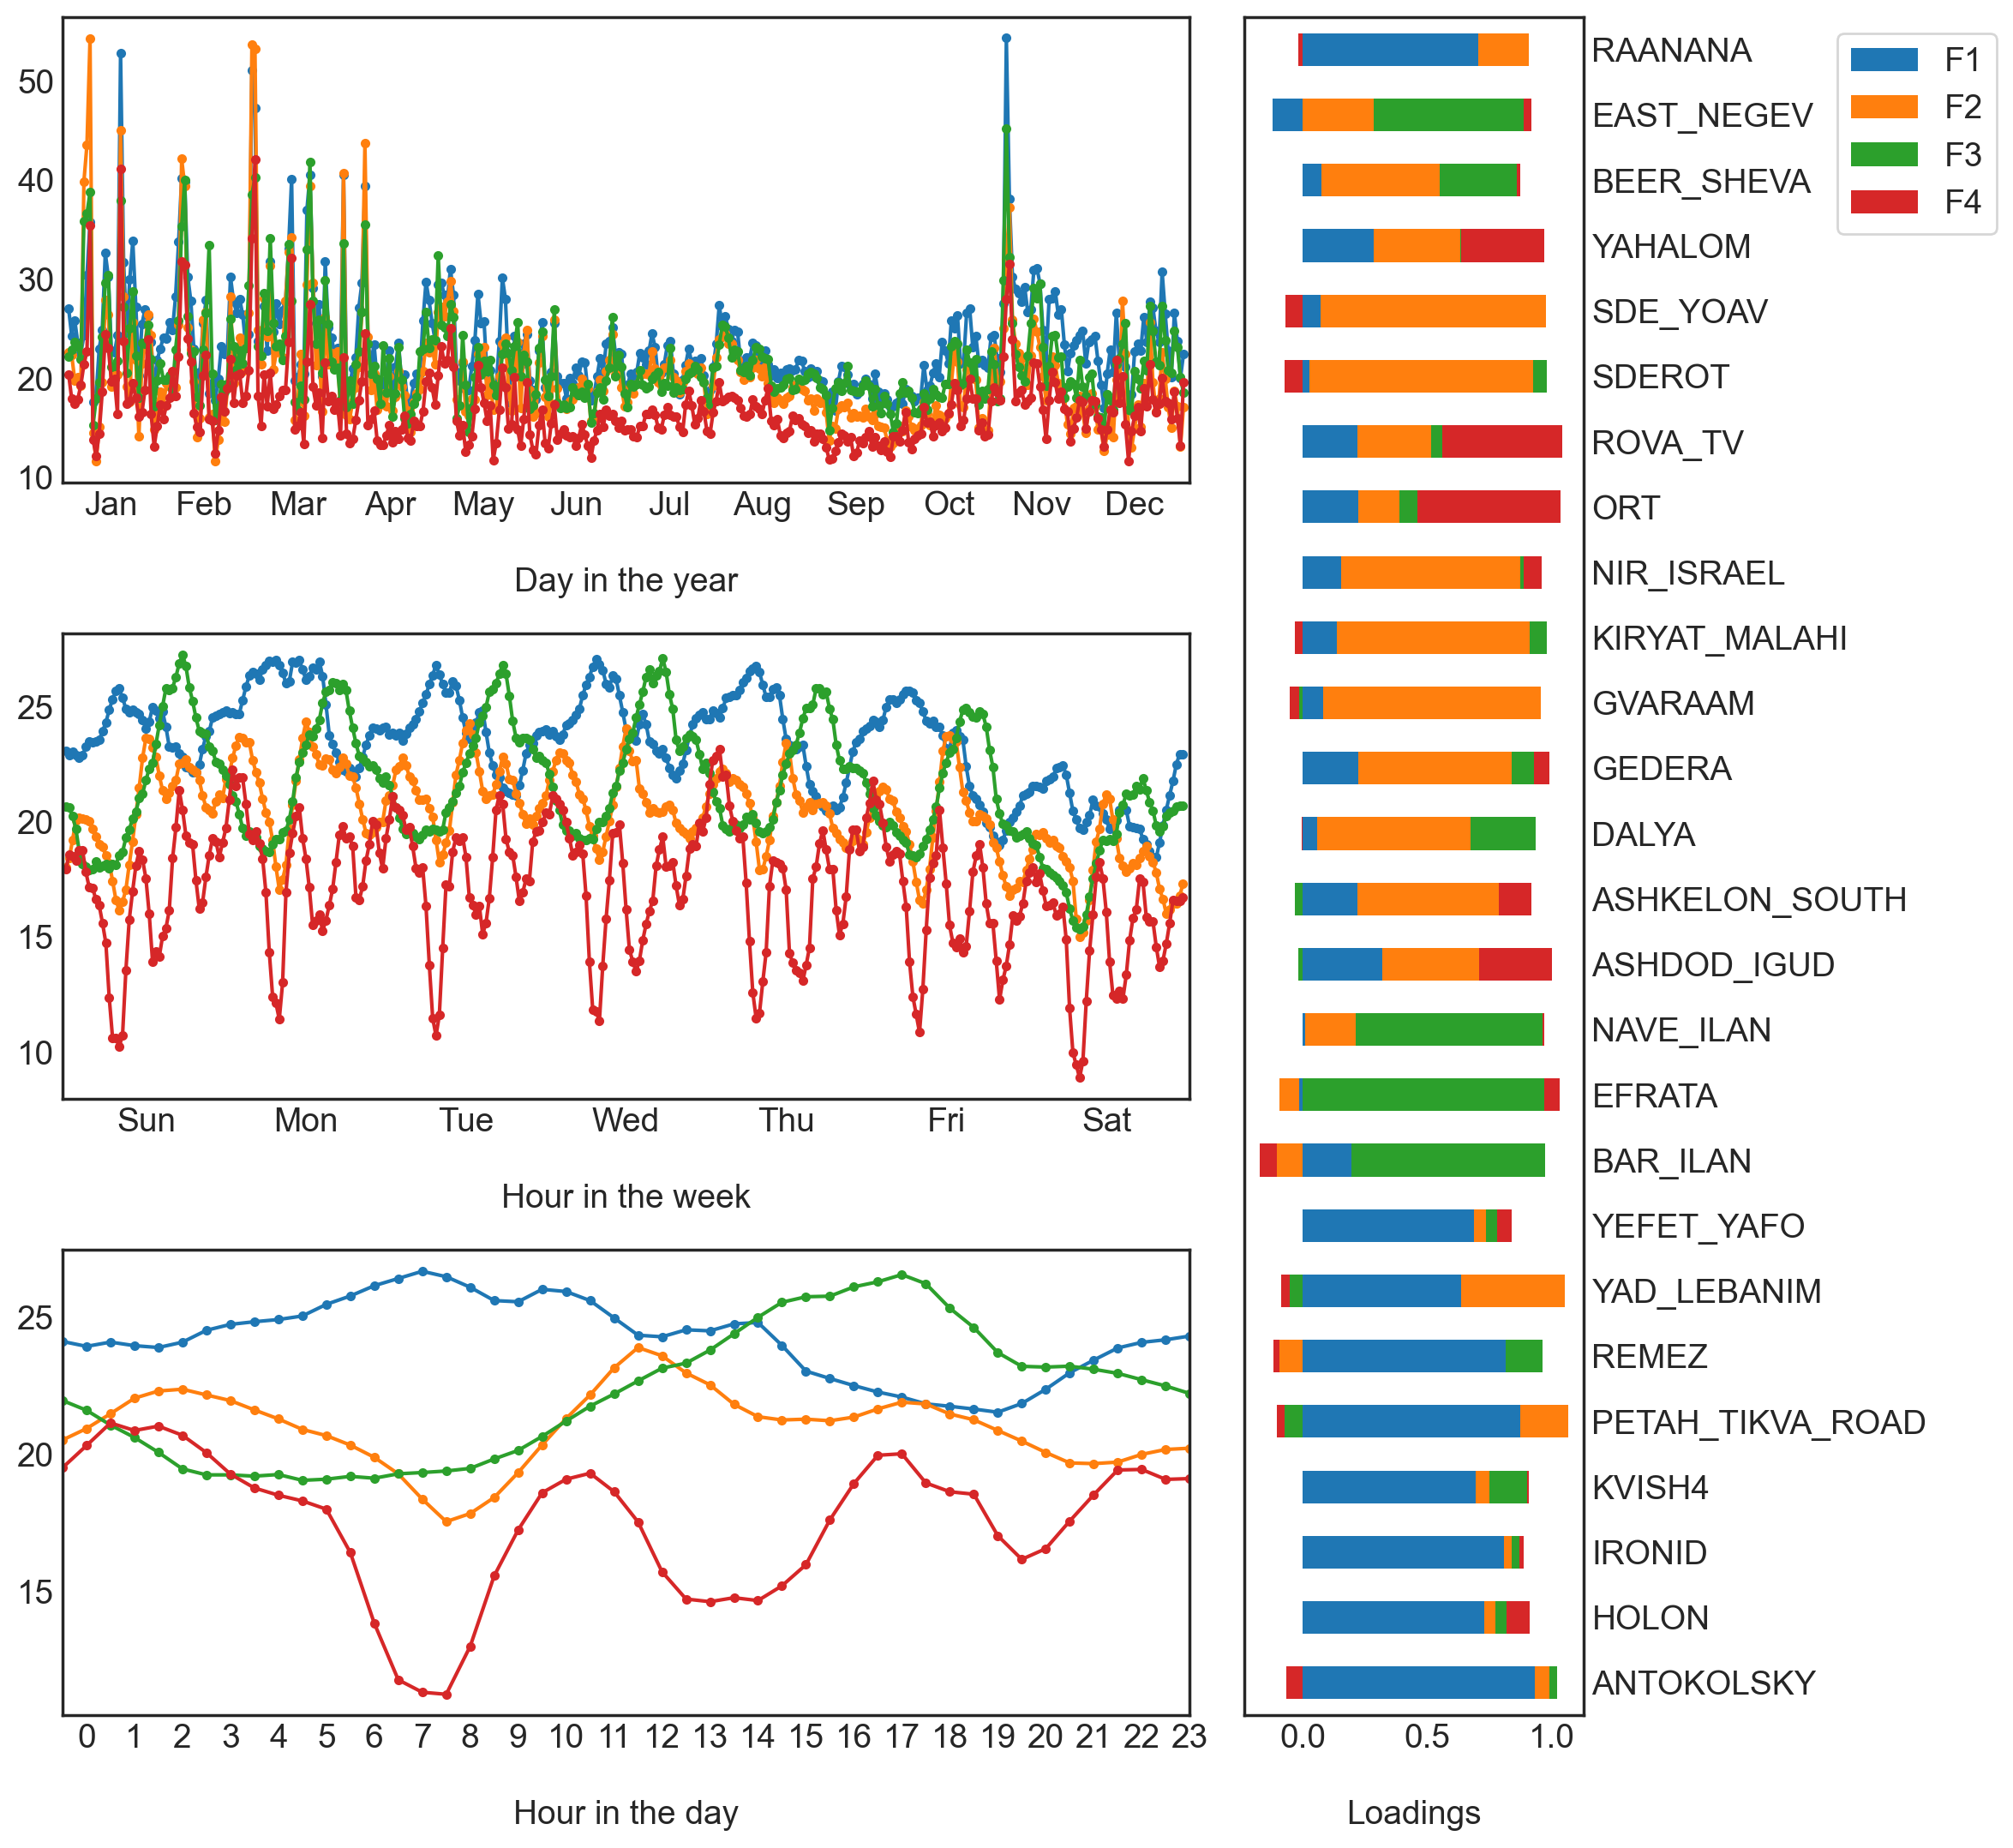

In [963]:
list_of_factors = ['F'+str(i+1) for i in range(NUM)]

df_scores = add_group_columns_to_df_scores(df_scores,times)
to_save = False
plot_factors_and_loadings(df_scores, df_load, list_of_factors, column_names, weekend_removed, to_save)

In [714]:
# Add units in the y axis

In [715]:
times.iloc[np.argmax(F[0,:])]

time    2015-11-04 17:30:00
Name: 66947, dtype: object

In [716]:
# https://www.israelhayom.co.il/article/81351

In [717]:
reconstructed = np.dot(df_load,F).T

In [718]:
# report standardized residuals since each station has its ows mean and std. 

In [719]:
# residulas = (observed - predicted)/std((observed - predicted))
r = df.values - reconstructed
# std_r = (r)/(np.std(r,axis = 0))

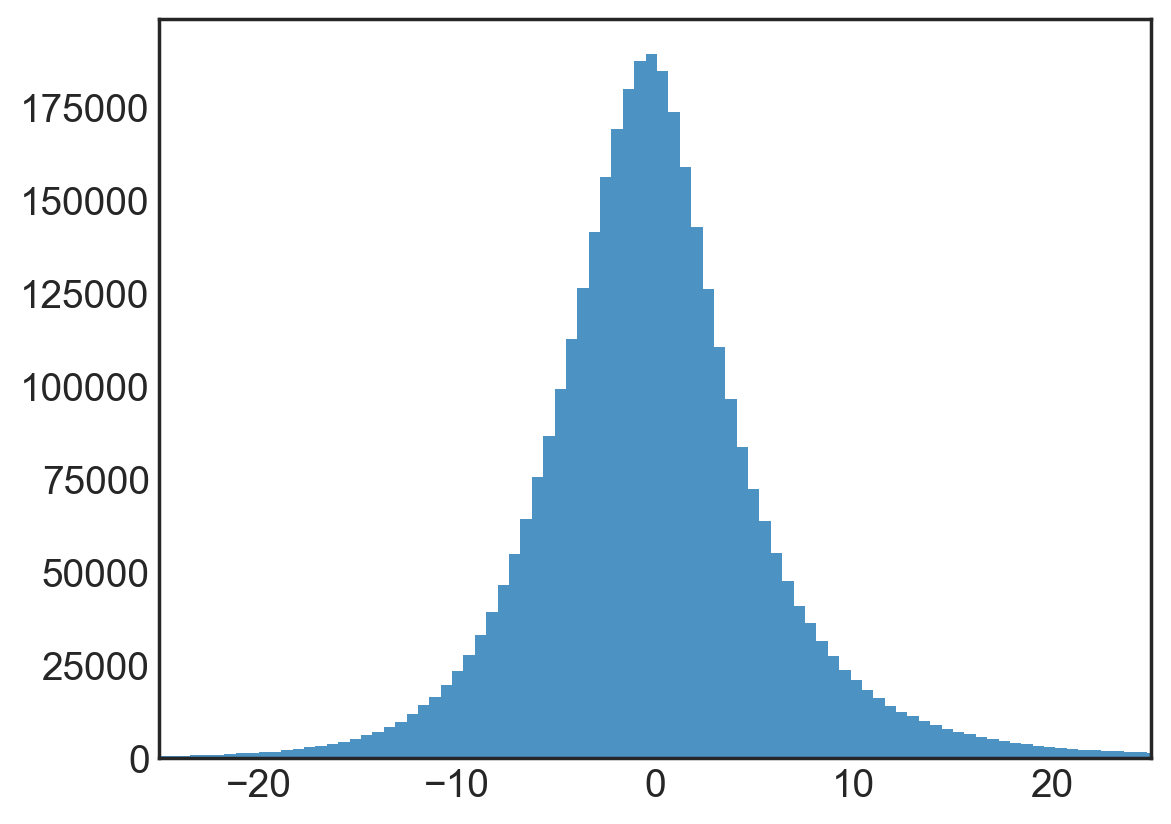

In [720]:
plt.hist(r.flatten(),alpha = 0.8,bins=3000);
plt.xlim([-25,25]);

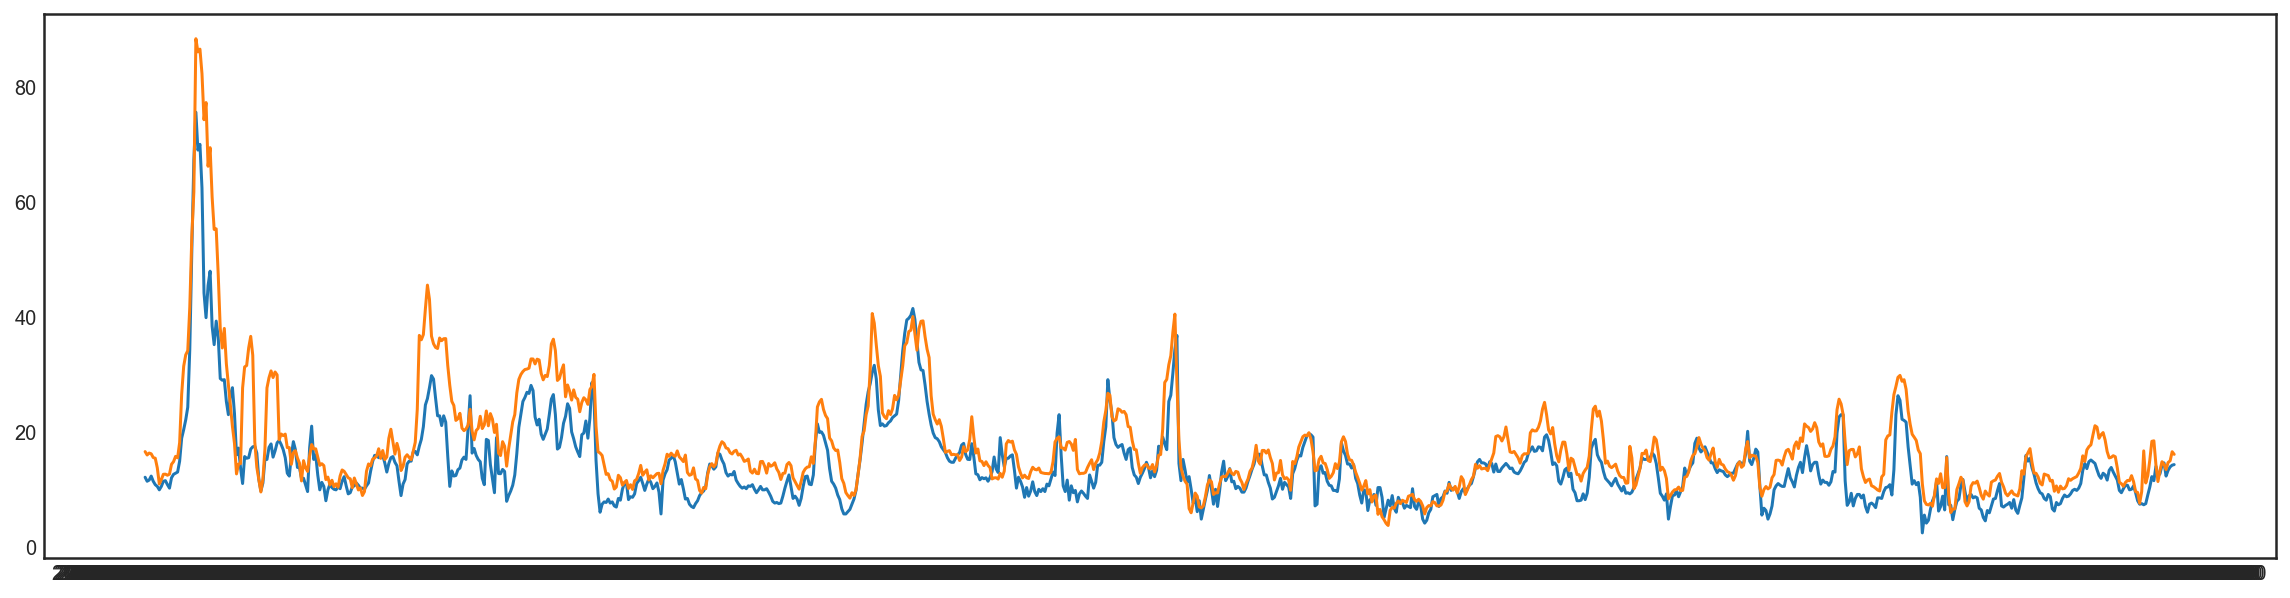

In [416]:
%matplotlib inline

ax, fig = plt.subplots(figsize = (20,5))

plt.plot(times.iloc[:100].time,df.iloc[:100,0])
plt.plot(times.iloc[:100].time,reconstructed[:100,0])

# Look at the factors and hope for good

In [933]:
Z0 = np.dot(np.transpose(df_load.iloc[:,0].values.reshape(1,-1)),df_scores.iloc[:,0].values.reshape(1,-1))
Z1 = np.dot(np.transpose(df_load.iloc[:,1].values.reshape(1,-1)),df_scores.iloc[:,1].values.reshape(1,-1))
Z2 = np.dot(np.transpose(df_load.iloc[:,2].values.reshape(1,-1)),df_scores.iloc[:,2].values.reshape(1,-1))
Z3 = np.dot(np.transpose(df_load.iloc[:,3].values.reshape(1,-1)),df_scores.iloc[:,3].values.reshape(1,-1))

In [934]:
Z = np.dstack([Z0,Z1,Z2,Z3])
# Z = np.dstack([Z0,Z1,Z2])

In [935]:
Z.shape

(26, 139824, 4)

In [936]:
np.argwhere(df.columns==st)

array([[25]])

In [937]:
factorsSelect = widgets.Select(
    options=np.arange(len(list_of_factors)),
    value=1,
    description='Factor',
    disabled=False
)

stationsSelect = widgets.Select(
    options=list(df.columns.values),
    description='Station',
    value = 'ANTOKOLSKY',
    disabled=False
)

slider_xlim = widgets.IntSlider(
    min=10,
    max=100,
    step=5,
    value=30
)

@interact(stations=stationsSelect, variables=factorsSelect, xlim=slider_xlim)

def f(stations, variables, xlim):
    plt.hist(Z[np.argwhere(df.columns==stations)[0][0],:,variables].flatten(),alpha = 0.8,bins=700);
    plt.xlim([-5,xlim]);

interactive(children=(Select(description='Station', options=('ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'PETAH_TIKVA_ROAD', 'REMEZ', 'YAD_LEBANIM', 'YEFET_YAFO', 'BAR_ILAN', 'EFRATA', 'NAVE_ILAN', 'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'DALYA', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM', 'BEER_SHEVA', 'EAST_NEGEV', 'RAANANA'), value='ANTOKOLSKY'), Select(description='Factor', index=1, options=(0, 1, 2, 3), value=1), IntSlider(value=30, description='xlim', min=10, step=5), Output()), _dom_classes=('widget-interact',))

In [343]:
# Z[np.argwhere(df.columns=='ATZMAUT_B')[0][0],:,2]

In [344]:
# df_Z2 = pd.DataFrame(Z2.T,columns = df.columns)

In [345]:
# ind_to_start = np.argwhere(np.array([times.time == str(2017)+'-01-01 00:30:00']))[0][1]
# df_Z2 = df_Z2.iloc[ind_to_start:,]
# df_Z2.reset_index(inplace=True,drop=True)

In [346]:
# df_Z2.to_pickle('~/Documents/Broday/saved_data_from_notebooks/TRAFFIC_FA')

# NMF

In [372]:
NUM = 3
weekend_removed = False
list_of_factors = ['Factor'+str(i+1) for i in range(NUM)]

In [373]:
rs = 0#100

In [374]:
W, H, n_iter = non_negative_factorization(df, n_components=NUM, init='nndsvd', random_state=rs, max_iter=2000)
# init = 'nndsvd' - better for sparse matrix 
# 'random' = matrices are scaled with: sqrt(X.mean() / n_components)
# "Ideally H will be somewhat sparse -- you would like to measure species that are, if not unique to a source, at least specific to a group of sources"
W.shape
H.shape
n_iter

(139824, 3)

(3, 27)

339

In [375]:
column_names = df.columns

In [376]:
df_load = pd.DataFrame(H.T,columns=list_of_factors)
df_scores = pd.DataFrame(W, columns=list_of_factors)

In [377]:
# scaling
df_scores = np.max(df_load.max())*df_scores
df_load = df_load/np.max(df_load.max())

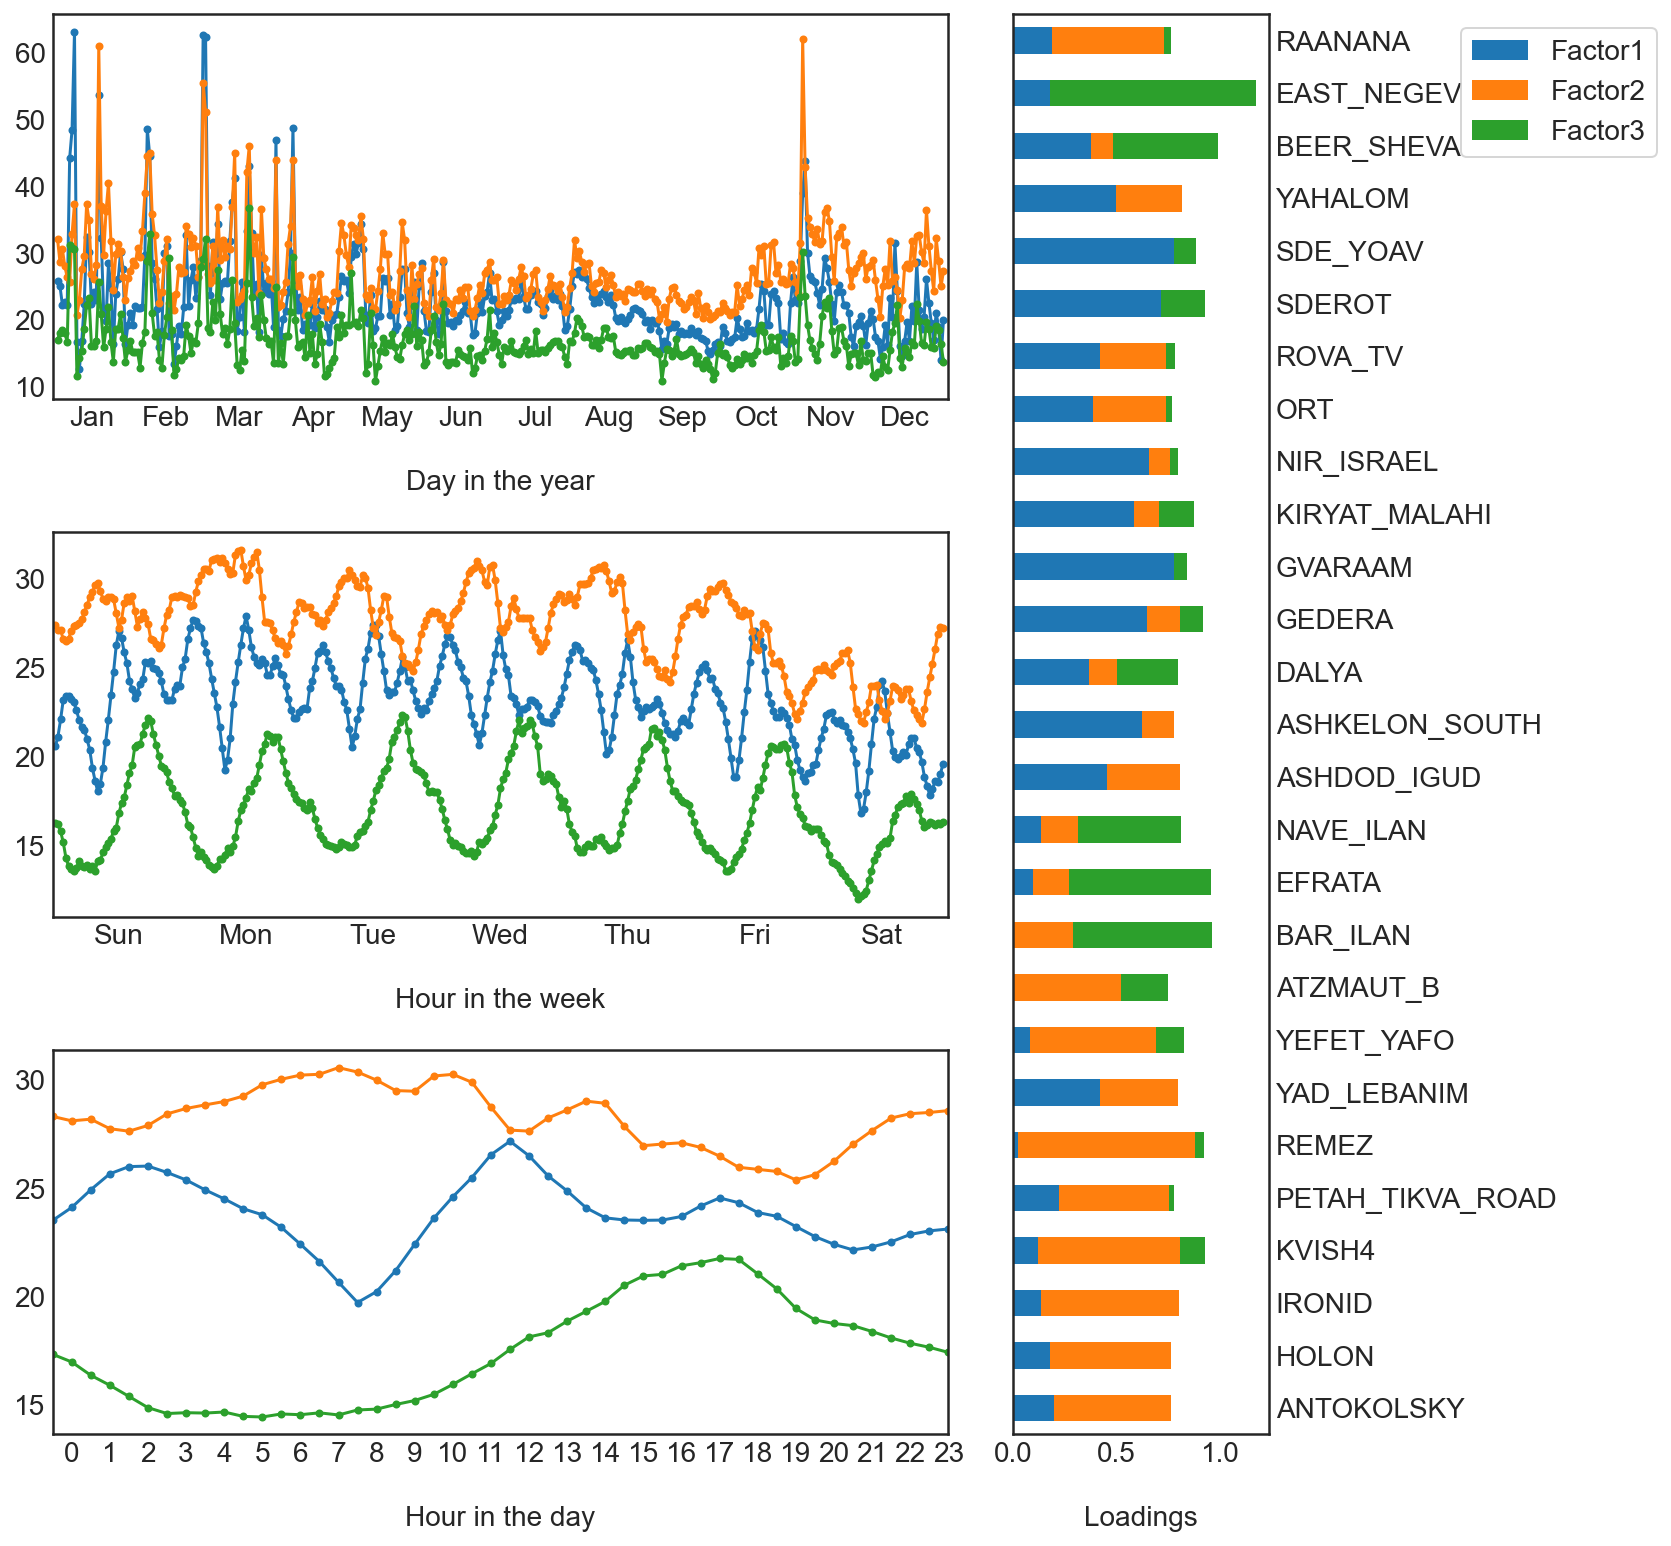

In [378]:
df_scores = add_group_columns_to_df_scores(df_scores,times)

to_save = False
plot_factors_and_loadings(df_scores, df_load, list_of_factors, column_names, weekend_removed, to_save)

In [417]:
# CONCLUSIONS:
# promax gives similar results to MNF, but when the contribution in a station is zero then it cannot give zero, it gives negative 
# contributions instead (does that mean that NMF is over estimating or FA underestimating?)
# Varimax on the other hand just gives a negative tail to everyone. 
# So maybe promax with ignoring stations that give negative contribution to traffic will work.
# OR just refer to it as PCA and look at negative Vs. positive

# FA maps

In [981]:
import metpy as mp
import metpy.calc as mpcalc
from metpy.units import units
from IPython import display

In [982]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

InteractiveShell.ast_node_interactivity = "last_expr"

In [940]:
# import wind data for stations

In [941]:
# data_df = pd.read_csv('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/data_df', index_col = [0,1])

In [942]:
df_WD = pd.DataFrame([],columns = df.columns)
df_WS = pd.DataFrame([],columns = df.columns)
df_met_WD = pd.DataFrame([],columns = df.columns)
df_met_WS = pd.DataFrame([],columns = df.columns)

In [943]:
for st in df.columns:
    df_WD[st] = data_df.loc[st].WD.values
    df_WS[st] = data_df.loc[st].WS.values
    df_met_WD[st] = data_df.loc[st].met_WD.values
    df_met_WS[st] = data_df.loc[st].met_WS.values

In [944]:
# unite WS, WD with met_WS and met_WD
df_WD[df_WD.isnull()] = df_met_WD[df_WD.isnull()]
df_WS[df_WS.isnull()] = df_met_WS[df_WS.isnull()]

In [945]:
# remove 2015 storms from wind data
df_WD.drop(idx_to_drop,axis = 0, inplace=True)
df_WS.drop(idx_to_drop,axis = 0, inplace=True)

In [946]:
df_WD.shape
df_WS.shape

(139824, 26)

(139824, 26)

In [947]:
for f in list_of_factors:    
    stations[f]=np.nan

In [948]:
# making it blue and red 

In [985]:
times.time[t]

'2012-01-01 00:00:00'

In [990]:
# NOTE THAT THE PROJECTION IS WRONG. SHOULD BE PRESENTED IN TRAVERSE MERCATOR ISRAELI ITM. 

for t in range(len(times)): 
    
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df_geo = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(color='w',edgecolor='k')

    for st in df.columns:
        # preper data
        # turn to U and V components
        U,V = mpcalc.wind_components(df_WS[st].values[t]* units('m/s'),df_WD[st].values[t]* units.deg)
        for factor in range(len(list_of_factors)):
            stations.loc[stations.Name==st,list_of_factors[factor]] = Z[np.argwhere([stations.Name==st])[0][1],t,factor].flatten()

        # plot it
        plt.quiver(stations[stations.Name==st].Lon.values, stations[stations.Name==st].Lat.values, U, V, units='xy',scale = 30, width=0.007); #,headwidth=2
    #     df_geo.plot(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0], markersize=stations[stations.Name==st].F1.values[0]) 
        plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F1.values[0])*5,c=cm[0])
    #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F2.values[0])*5,c=cm[1])
    #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F3.values[0])*5,c=cm[2])
#         plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F4.values[0])*5,c=cm[3])

    # plot concentrations
    # df_geo.plot(kind='scatter', x='Lon', y='Lat', s=df_geo['F1'])    
    # df_geo.plot(markersize=df_geo['F1'])

    plt.ylim(31.2,32.36)
    plt.xlim(34.42,35.36)
    plt.title(times.time[t])
#     plt.rcParams.update({'font.size': 14})
    display.clear_output(wait=True) 
    display.display(plt.gcf())
    plt.close()

    # plt.axis('equal')

# FA ML

# TRASH

In [902]:
mpl.style.use('seaborn-white')
#     cm = ['c','m','#d9534f','#9ad801']
cm = sns.color_palette(None, len(list_of_factors))

In [890]:
# # NOTE THAT THE PROJECTION IS WRONG. SHOULD BE PRESENTED IN TRAVERSE MERCATOR ISRAELI ITM. 

# plt.ion
# # change the Coordinate Reference System (CRS)
# gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
# df_geo = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
# ax = gdf.plot(color='w',edgecolor='k')

# t = 70000
# for st in df.columns:
#     # preper data
#     # turn to U and V components
#     U,V = mpcalc.wind_components(df_WS[st].values[t]* units('m/s'),df_WD[st].values[t]* units.deg)
#     for factor in range(len(list_of_factors)):
#         stations.loc[stations.Name==st,list_of_factors[factor]] = Z[np.argwhere([stations.Name==st])[0][1],t,factor].flatten()

#     # plot it
#     plt.quiver(stations[stations.Name==st].Lon.values, stations[stations.Name==st].Lat.values, U, V, units='xy',scale = 30, width=0.007); #,headwidth=2
# #     df_geo.plot(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0], markersize=stations[stations.Name==st].F1.values[0]) 
# #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F1.values[0])*5,c=cm[0])
# #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F2.values[0])*5,c=cm[1])
# #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F3.values[0])*5,c=cm[2])
# #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F4.values[0])*5,c=cm[3])

# # plot concentrations
# # df_geo.plot(kind='scatter', x='Lon', y='Lat', s=df_geo['F1'])    
# # df_geo.plot(markersize=df_geo['F1']) 

# plt.ylim(31.2,32.36)
# plt.xlim(34.42,35.36)
# plt.rcParams.update({'font.size': 14})
# plt.show();
# # plt.axis('equal')